In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from tasks.cluster_example import make_task

In [2]:
feature_precisions = [2, 2]

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [7]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 8.93 s, sys: 112 ms, total: 9.05 s
Wall time: 9.17 s


# Traditional SHAP Explanations

In [7]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [8]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

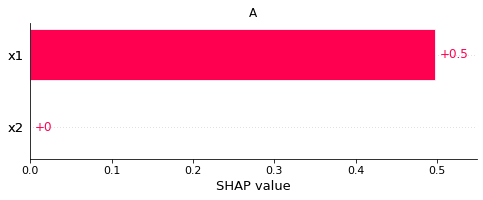

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

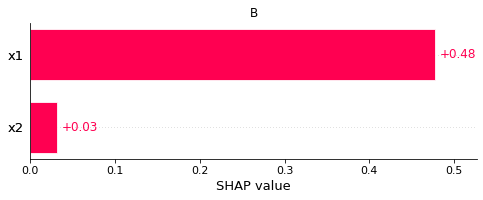

In [10]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [11]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 59.8 ms, sys: 5.94 ms, total: 65.7 ms
Wall time: 67.9 ms


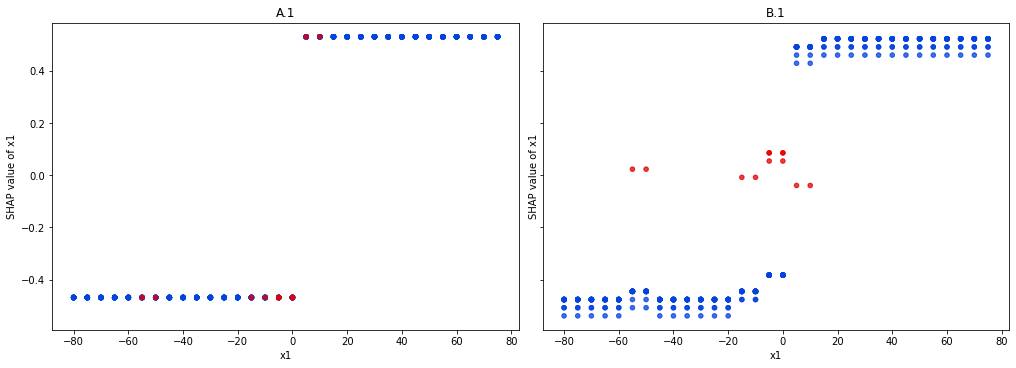

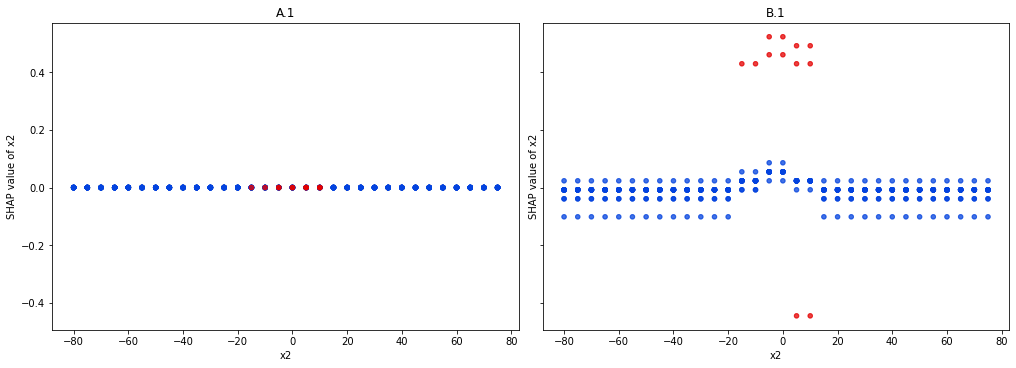

In [12]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [7]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

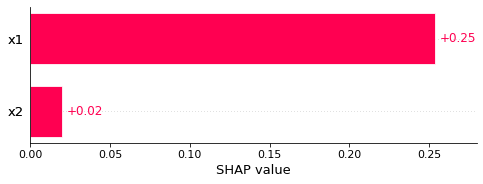

In [8]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

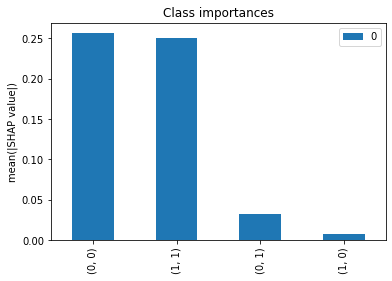

In [9]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [10]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 262 ms, sys: 7.96 ms, total: 270 ms
Wall time: 276 ms


((0, 0)    524
 (1, 1)    476
 (0, 1)     20
 (1, 0)      4
 dtype: int64,
 2.140625)

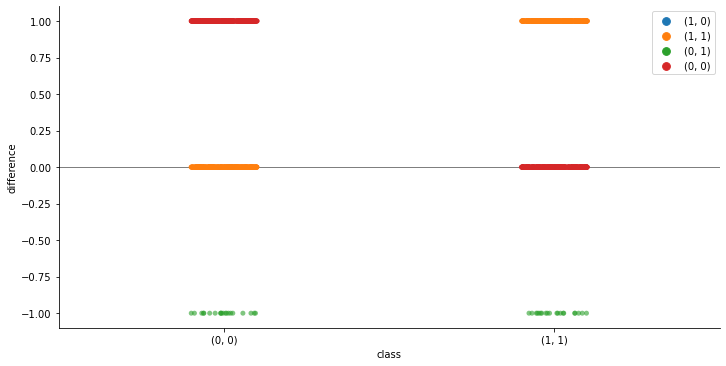

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [11]:
node.plot_outcome_differences()

### Node RL

In [12]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (0, 1)    20
 dtype: int64,
 0.037109375)

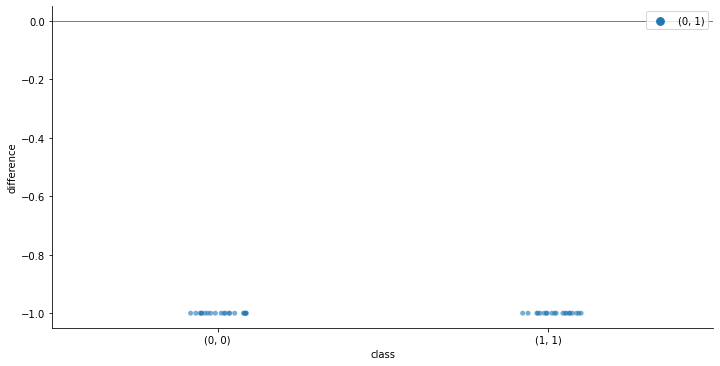

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [13]:
node.plot_outcome_differences()

-55.0 <= x1 <= 0.0
x1 <= -60.0 --> {'(0, 0)': 20}
x1 >= 0.01 --> {'(1, 1)': 12, '(1, 0)': 8}


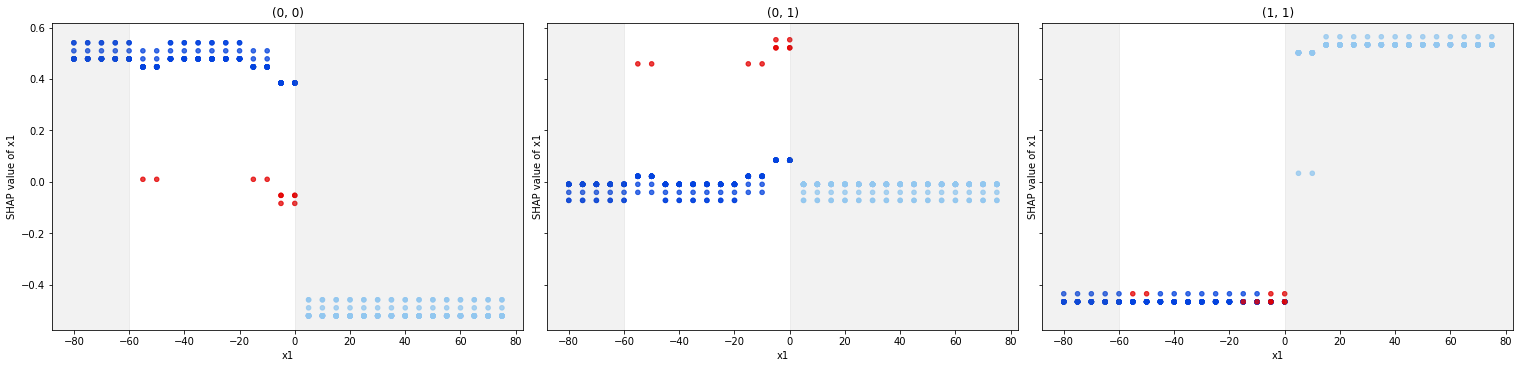

-15.0 <= x2 <= 10.0
x2 <= -20.0 --> {'(0, 0)': 20}
x2 >= 10.01 --> {'(0, 0)': 20}


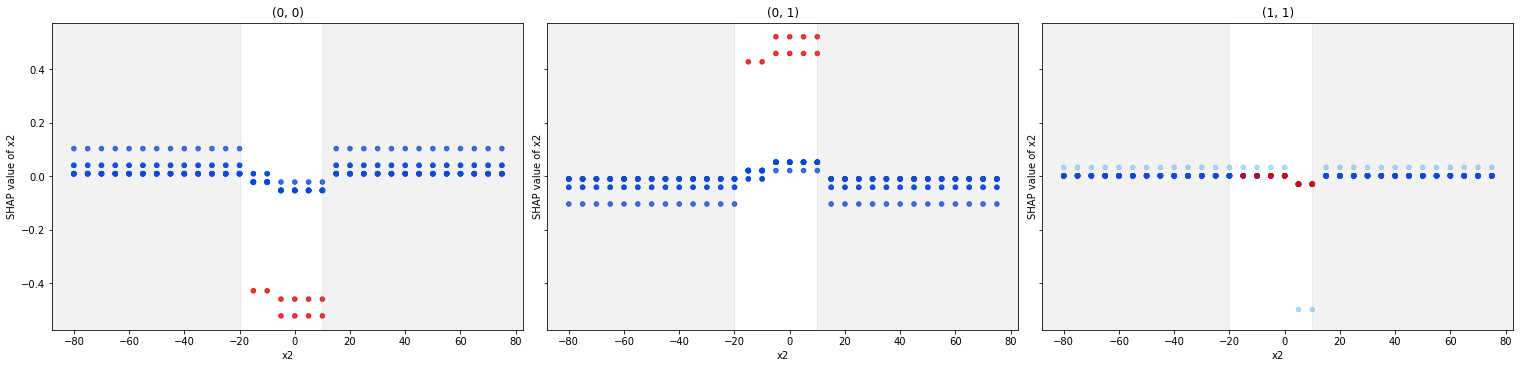

In [14]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

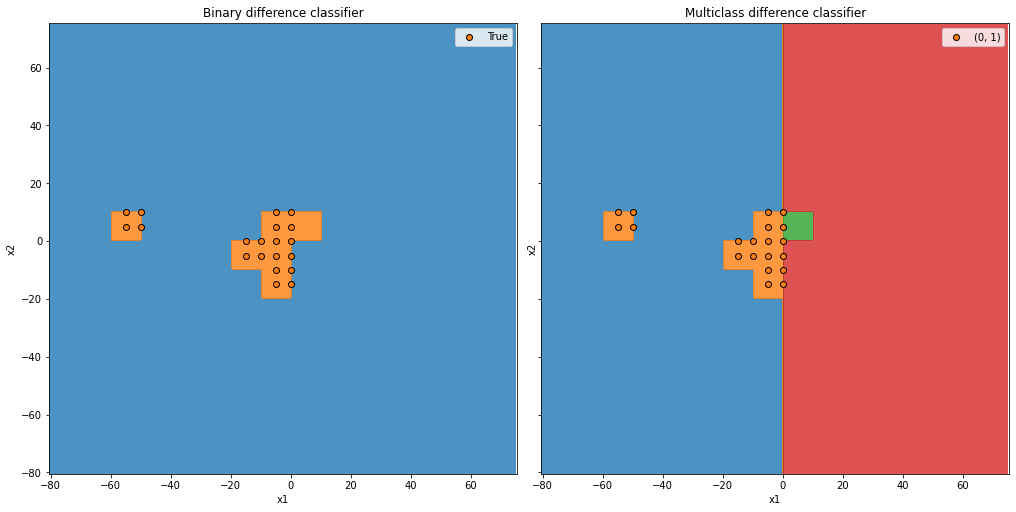

In [15]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim)

### Node RLL

In [21]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    8
 dtype: int64,
 0.001953125)

-55.0 <= x1 <= -10.0
x1 <= -60.0 --> {'(0, 0)': 8}
x1 >= 0.01 --> {'(1, 1)': 4, '(1, 0)': 4}


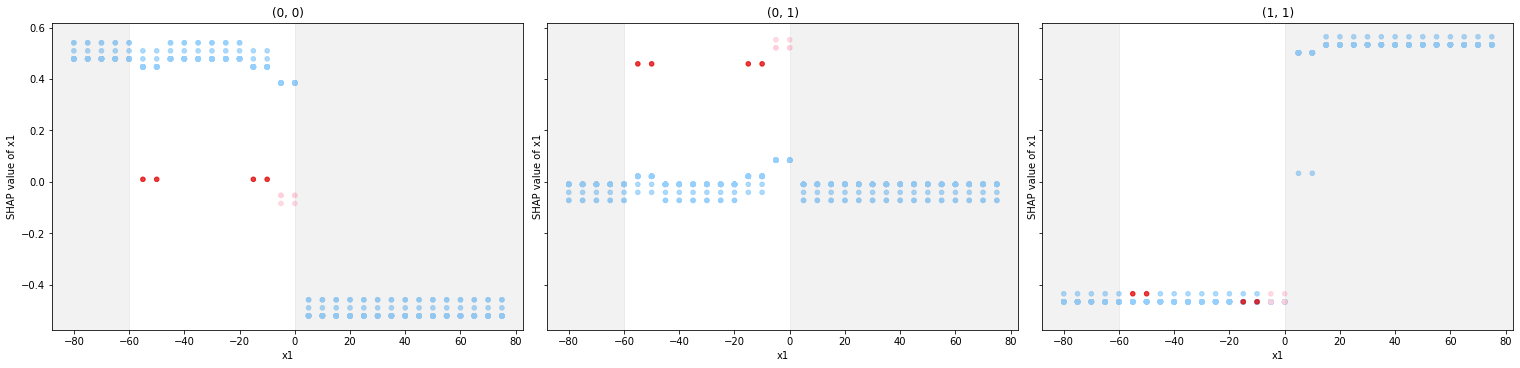

-5.0 <= x2 <= 10.0
x2 <= -10.0 --> {'(0, 0)': 8}
x2 >= 10.01 --> {'(0, 0)': 8}


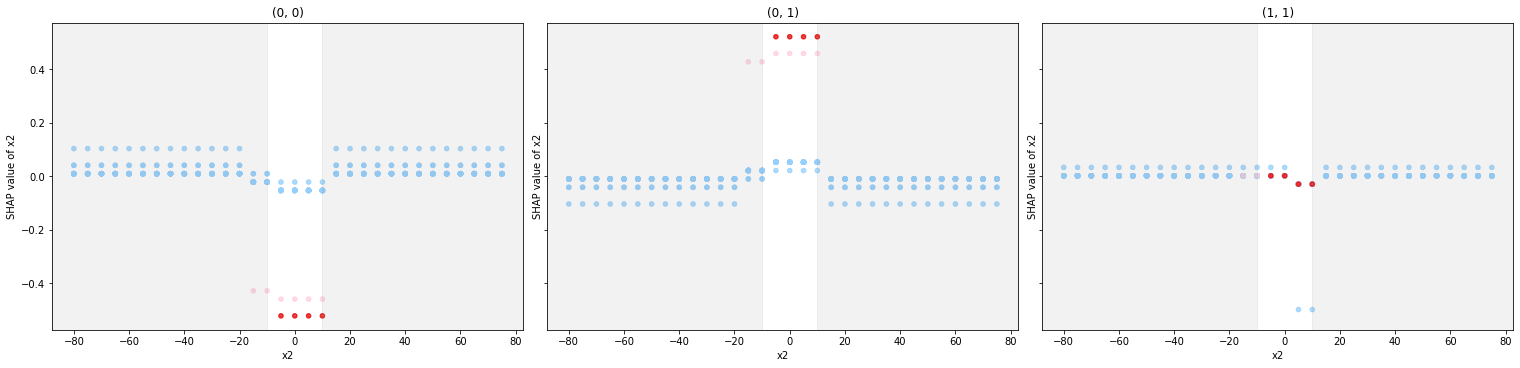

In [27]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

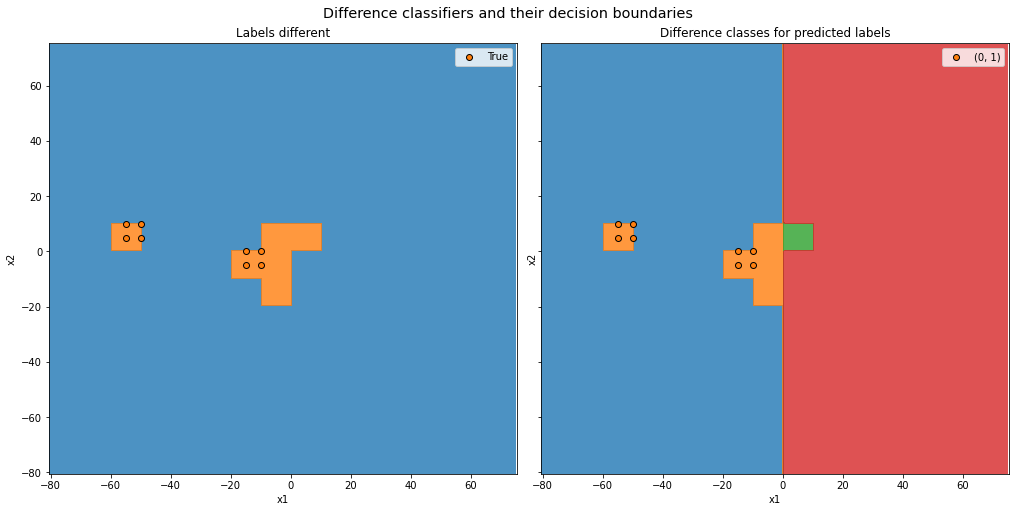

In [28]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLL

In [22]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    4
 dtype: int64,
 0.0)

We've cetainly reached the lowest layer, because the distance of these points is 0.

-15.0 <= x1 <= -10.0
x1 <= -20.0 --> {'(0, 0)': 4}
x1 >= 0.01 --> {'(1, 1)': 4}


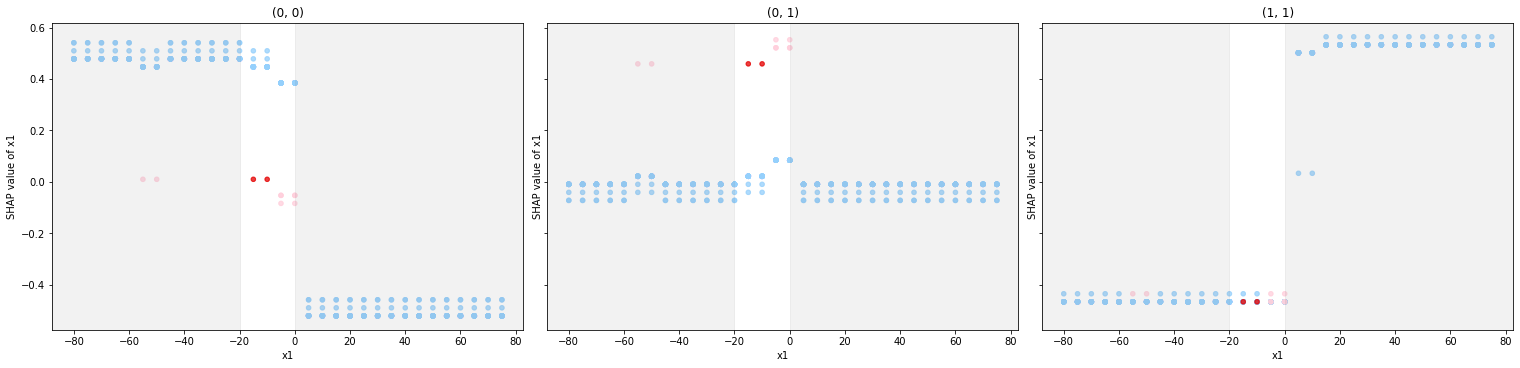

-5.0 <= x2 <= 0.0
x2 <= -10.0 --> {'(0, 0)': 4}
x2 >= 0.01 --> {'(0, 0)': 4}


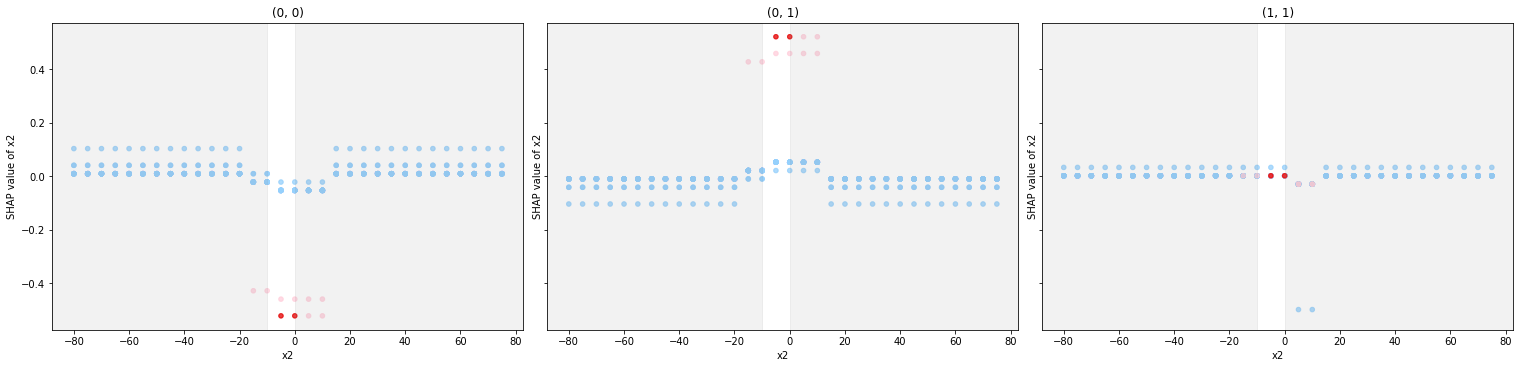

In [31]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

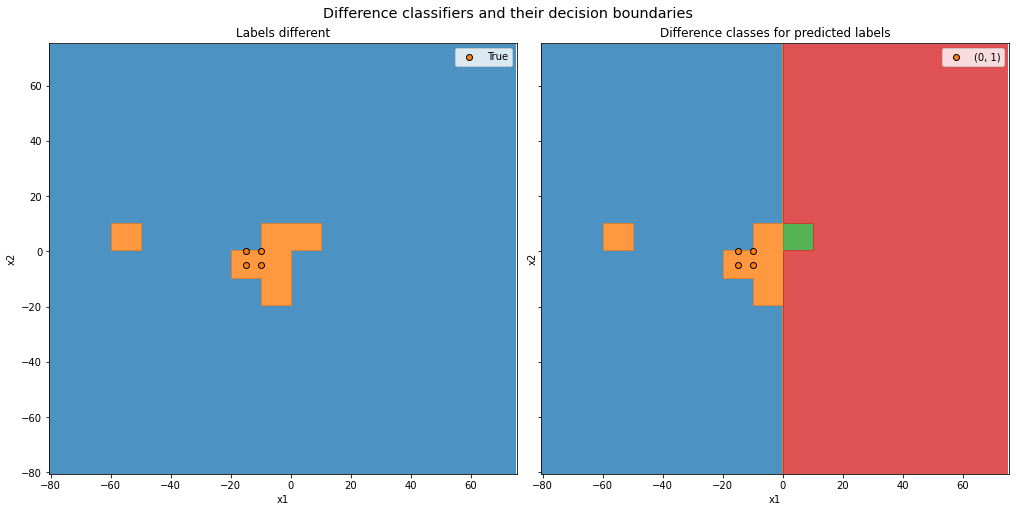

In [32]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLLR

In [23]:
node = node.parent.get_right()
node.class_counts, node.distance

((0, 1)    4
 dtype: int64,
 0.0)

-55.0 <= x1 <= -50.0
x1 <= -60.0 --> {'(0, 0)': 4}
x1 >= -49.99 --> {'(0, 0)': 4}


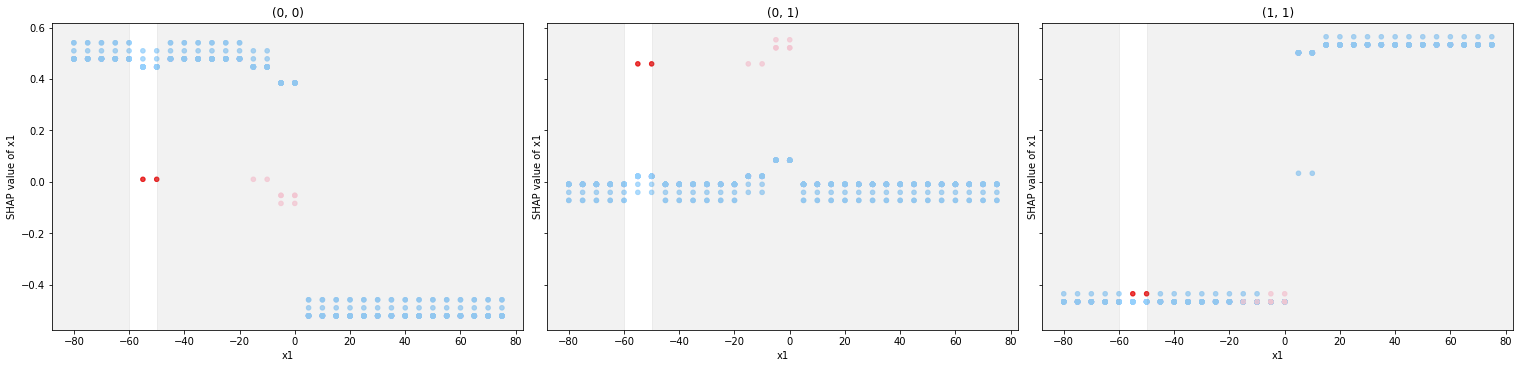

5.0 <= x2 <= 10.0
x2 <= 0.0 --> {'(0, 0)': 4}
x2 >= 10.01 --> {'(0, 0)': 4}


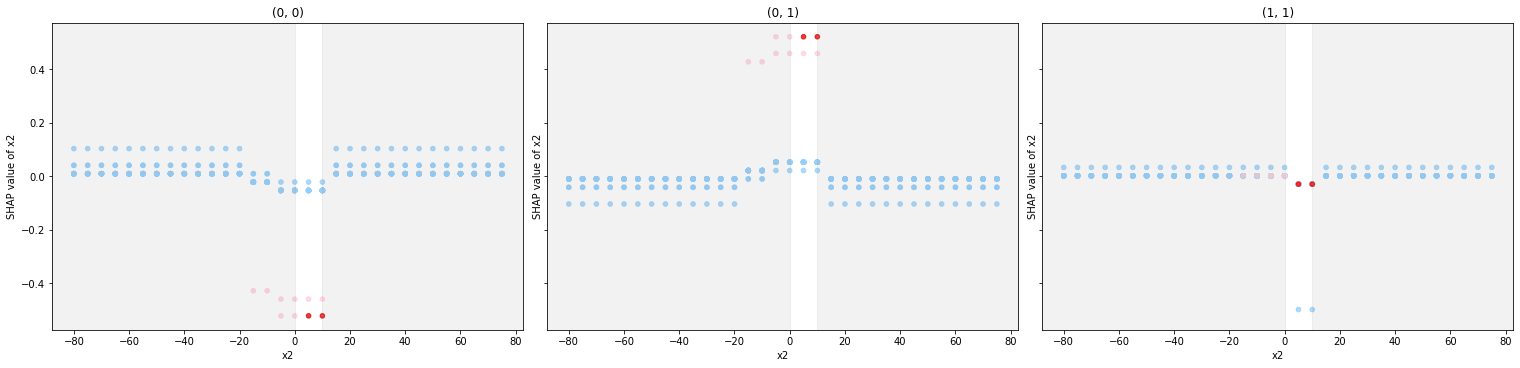

In [34]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

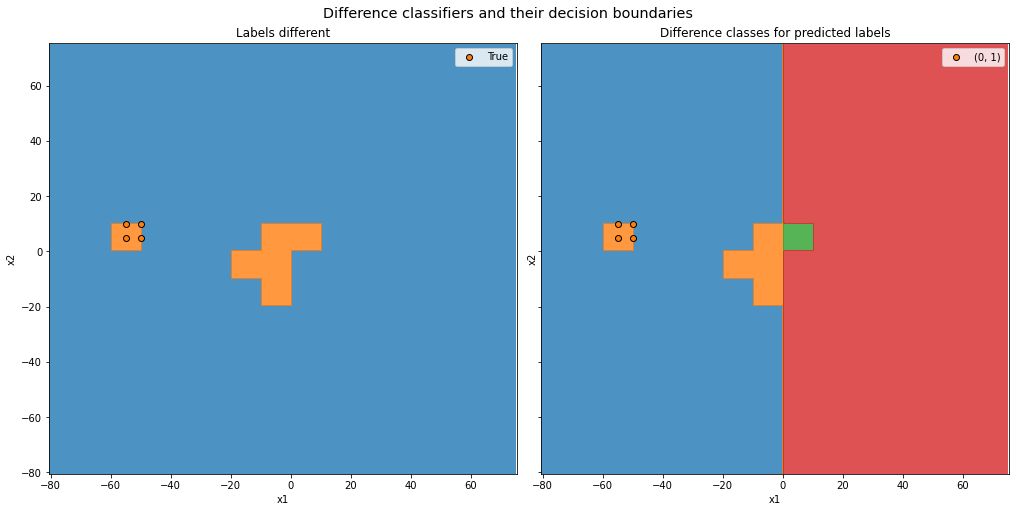

In [35]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLR

In [24]:
node = node.parent.parent.get_right()
node.class_counts, node.distance

((0, 1)    12
 dtype: int64,
 0.005859375)

-5.0 <= x1 <= 0.0
x1 <= -20.0 --> {'(0, 0)': 12}
x1 >= 0.01 --> {'(1, 1)': 8, '(1, 0)': 4}


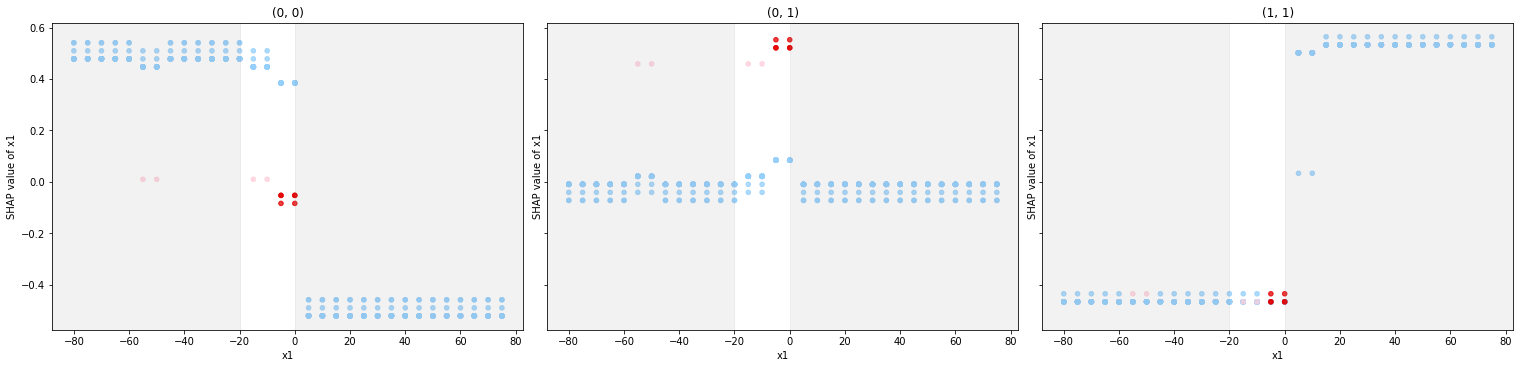

-15.0 <= x2 <= 10.0
x2 <= -20.0 --> {'(0, 0)': 12}
x2 >= 10.01 --> {'(0, 0)': 12}


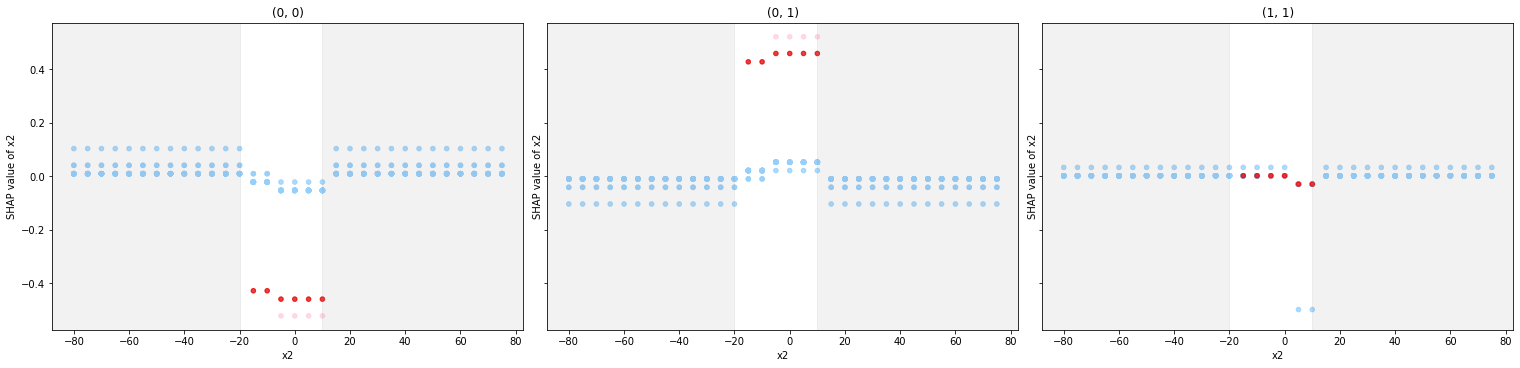

In [38]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

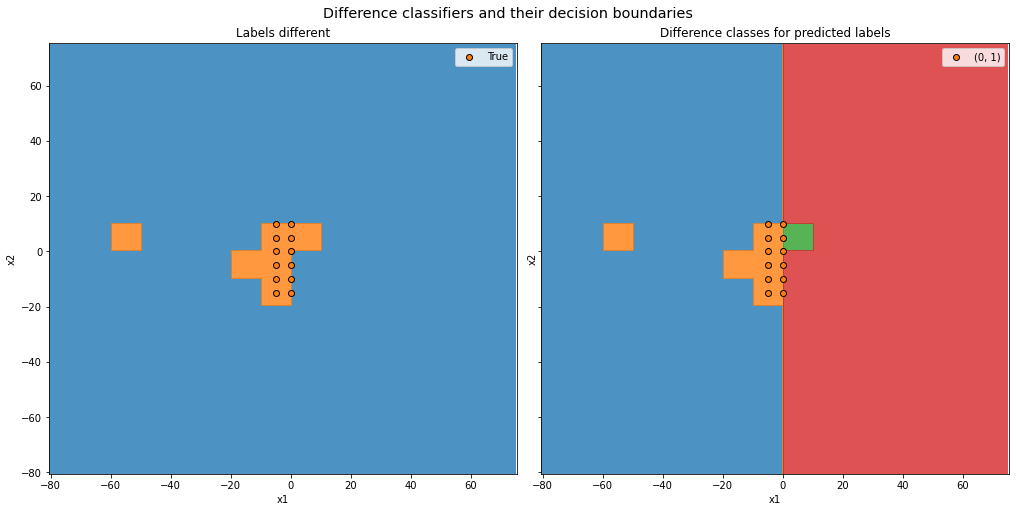

In [39]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRL

In [25]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    4
 dtype: int64,
 0.0)

-5.0 <= x1 <= 0.0
x1 <= -10.0 --> {'(0, 0)': 4}
x1 >= 0.01 --> {'(1, 1)': 4}


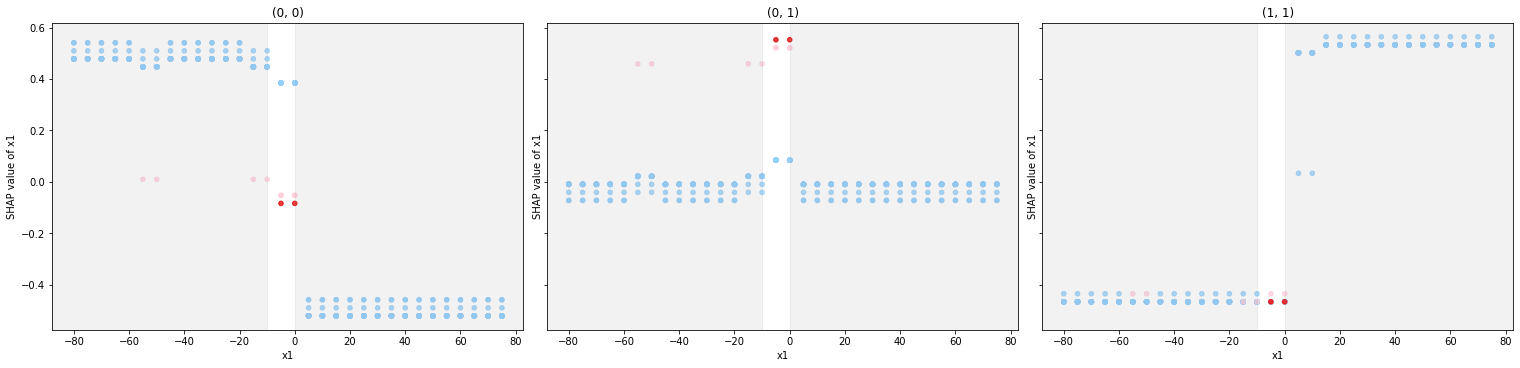

-15.0 <= x2 <= -10.0
x2 <= -20.0 --> {'(0, 0)': 4}
x2 >= 10.01 --> {'(0, 0)': 4}


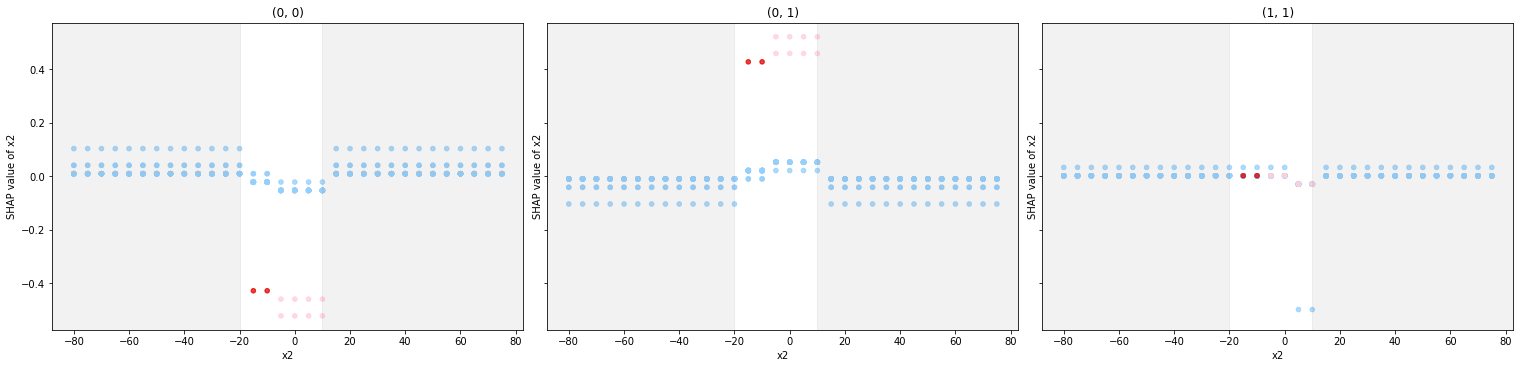

In [41]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

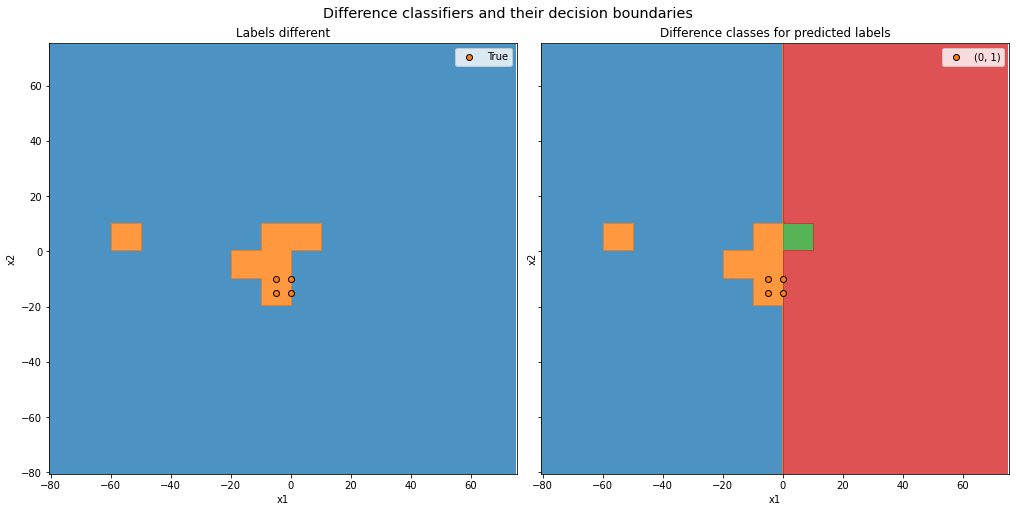

In [42]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRR

In [43]:
node = node.parent.get_right()
node.class_counts, node.distance

((0, 1)    8
 dtype: int64,
 0.001953125)

-5.0 <= x1 <= 0.0
x1 <= -20.0 --> {'(0, 0)': 8}
x1 >= 0.01 --> {'(1, 1)': 4, '(1, 0)': 4}


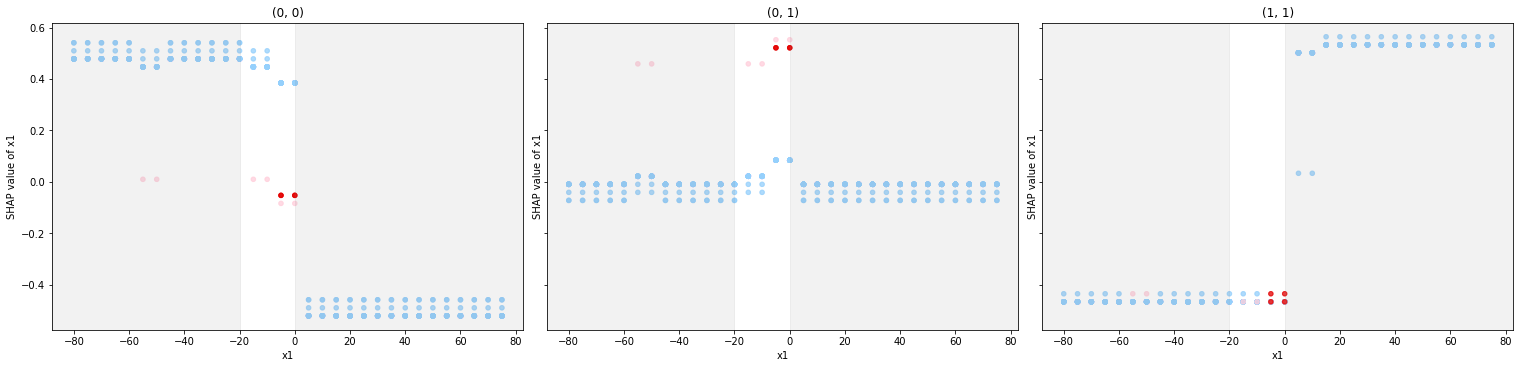

-5.0 <= x2 <= 10.0
x2 <= -20.0 --> {'(0, 0)': 8}
x2 >= 10.01 --> {'(0, 0)': 8}


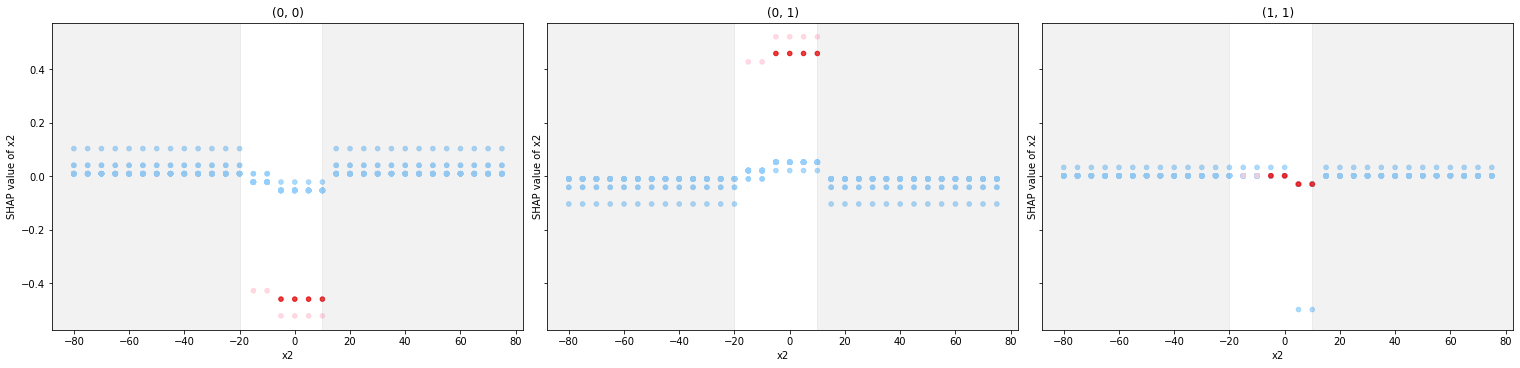

In [44]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

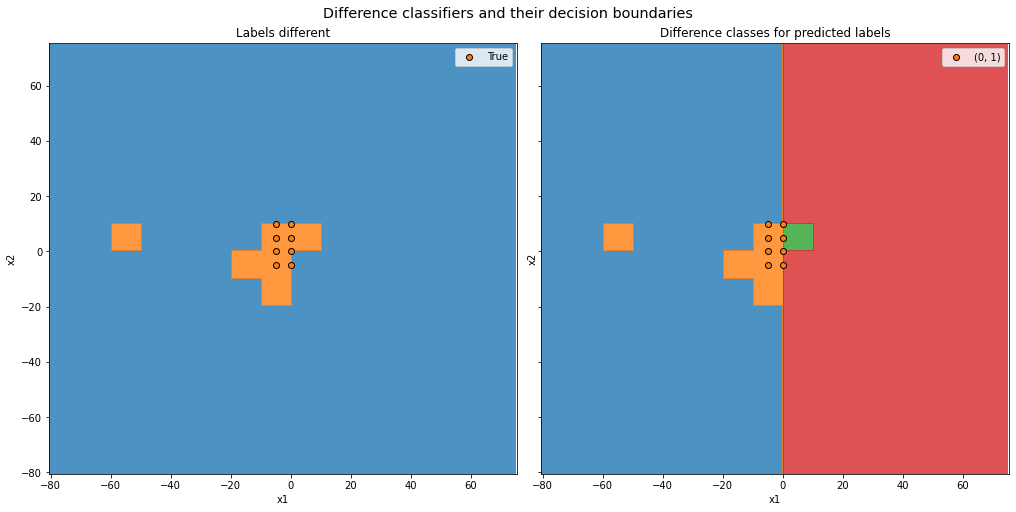

In [45]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRRL

In [46]:
node = node.get_left()
node.class_counts, node.distance

((0, 1)    4
 dtype: int64,
 0.0)

-5.0 <= x1 <= 0.0
x1 <= -20.0 --> {'(0, 0)': 4}
x1 >= 0.01 --> {'(1, 1)': 4}


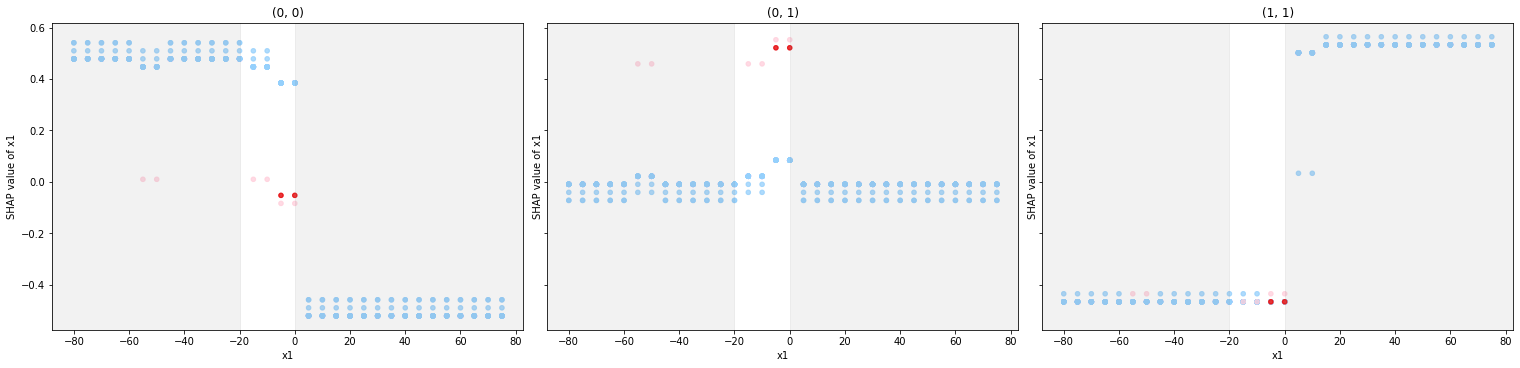

-5.0 <= x2 <= 0.0
x2 <= -20.0 --> {'(0, 0)': 4}
x2 >= 10.01 --> {'(0, 0)': 4}


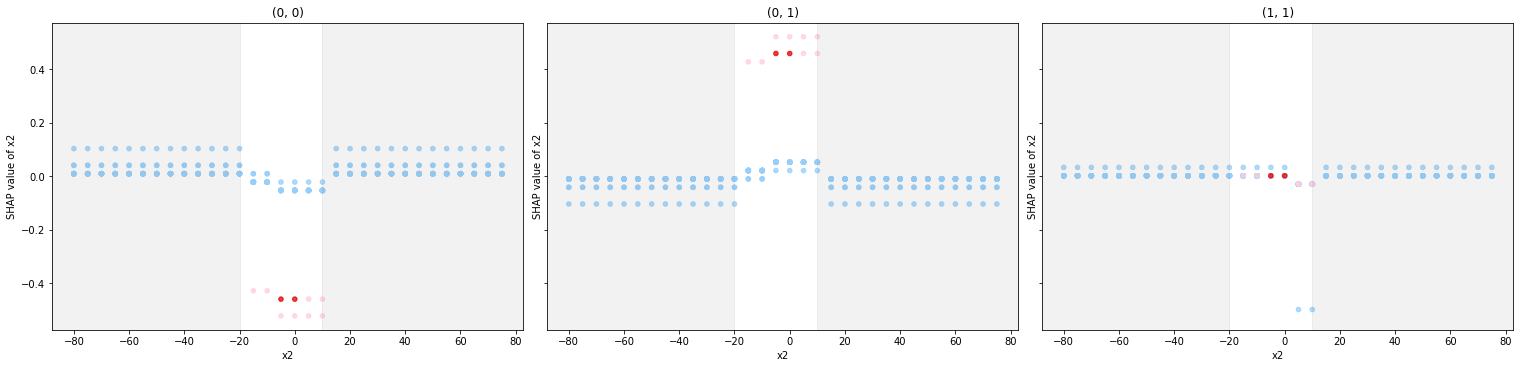

In [47]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

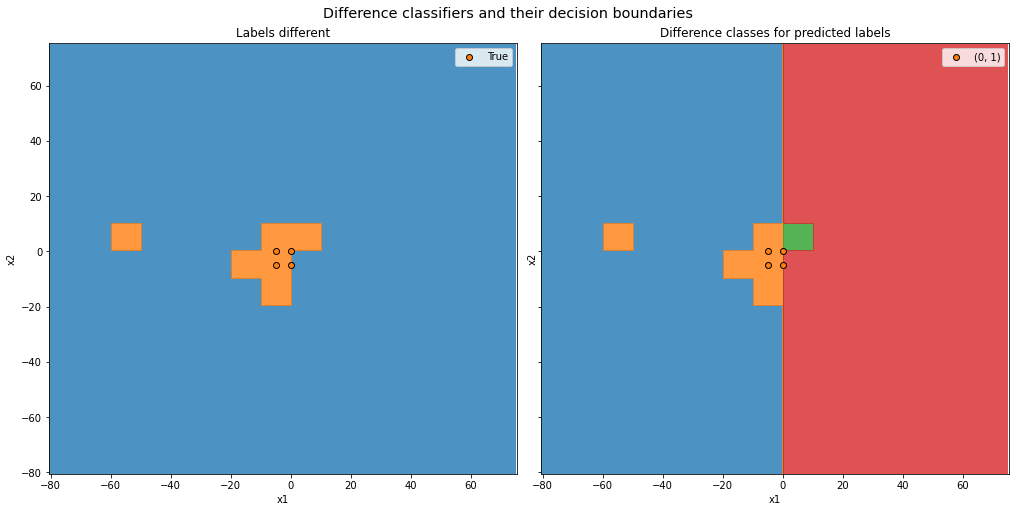

In [48]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

### Node RLRRR

In [49]:
node = node.parent.get_right()
node.class_counts, node.distance

((0, 1)    4
 dtype: int64,
 0.0)

-5.0 <= x1 <= 0.0
x1 <= -10.0 --> {'(0, 0)': 4}
x1 >= 0.01 --> {'(1, 0)': 4}


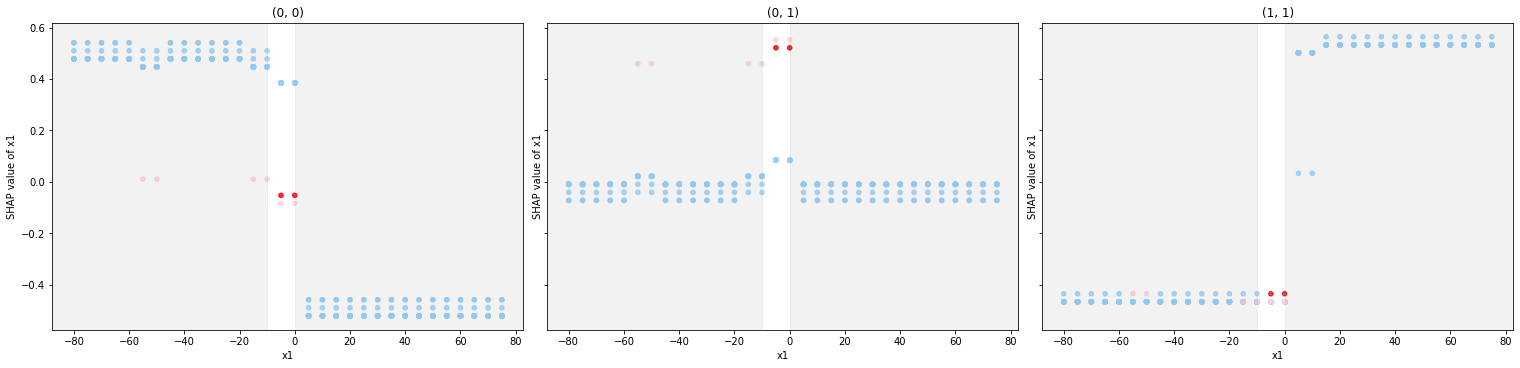

5.0 <= x2 <= 10.0
x2 <= -20.0 --> {'(0, 0)': 4}
x2 >= 10.01 --> {'(0, 0)': 4}


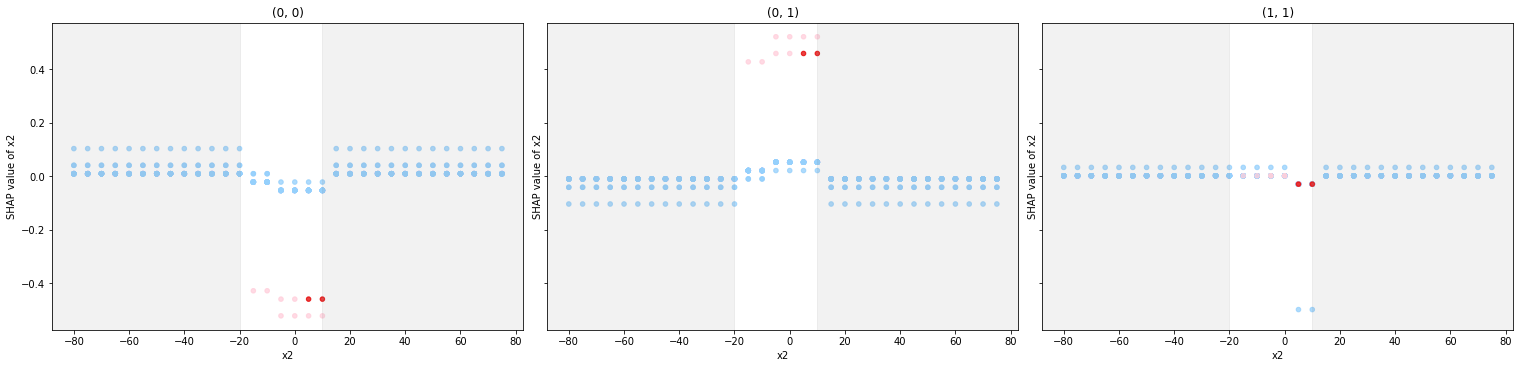

In [50]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

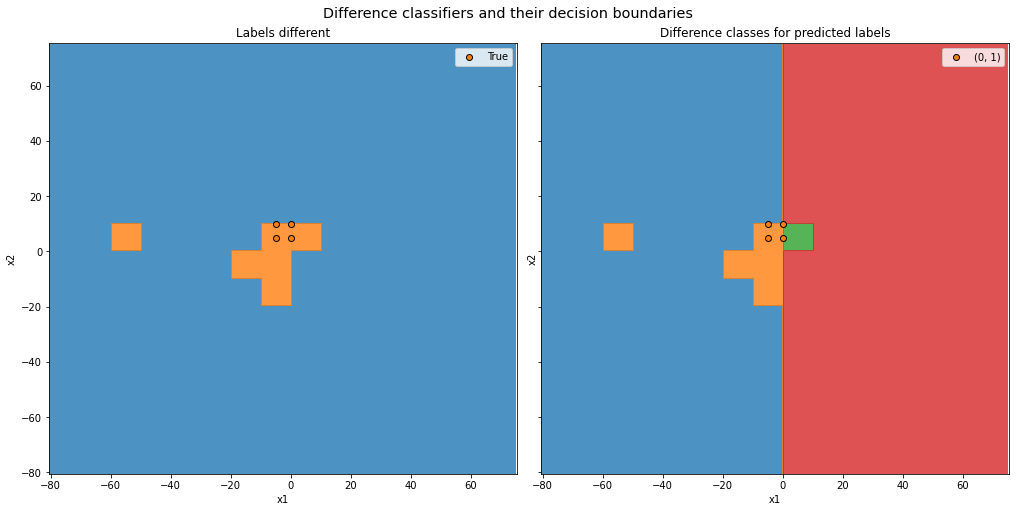

In [51]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

## Clustering of Class $(1,0)$ SHAP Values

In [29]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])
node.class_counts, node.distance

CPU times: user 112 ms, sys: 5.89 ms, total: 118 ms
Wall time: 127 ms


((0, 0)    524
 (1, 1)    476
 (0, 1)     20
 (1, 0)      4
 dtype: int64,
 2.1328125)

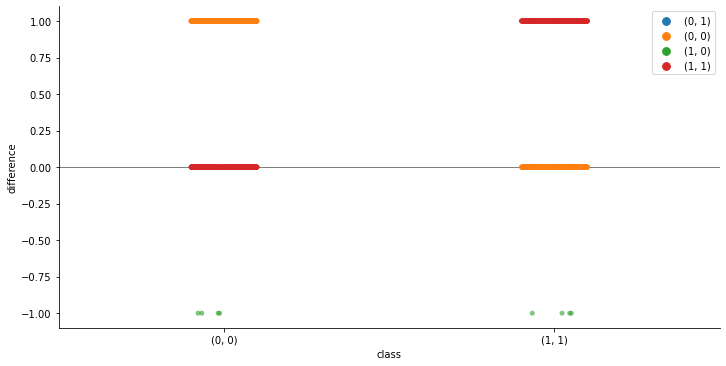

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [30]:
node.plot_outcome_differences()

### Node RL

In [31]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (1, 0)    4
 dtype: int64,
 0.0)

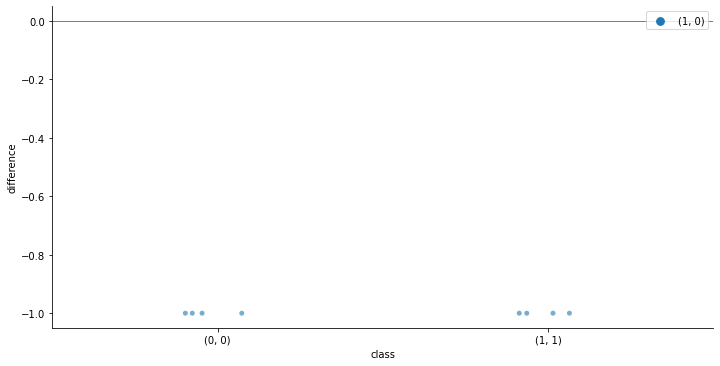

{'(0, 0)': '-1.0 to -1.0', '(1, 1)': '-1.0 to -1.0'}


In [32]:
node.plot_outcome_differences()

5.0 <= x1 <= 10.0
x1 <= 0.0 --> {'(0, 1)': 4}
x1 >= 11.0 --> {'(1, 1)': 4}


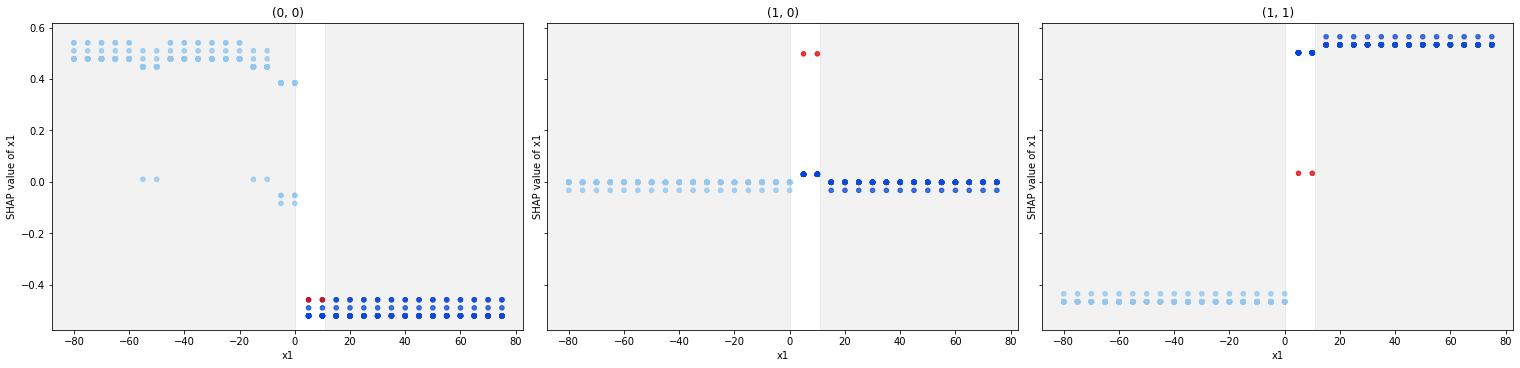

5.0 <= x2 <= 10.0
x2 <= 0.0 --> {'(1, 1)': 4}
x2 >= 11.0 --> {'(1, 1)': 4}


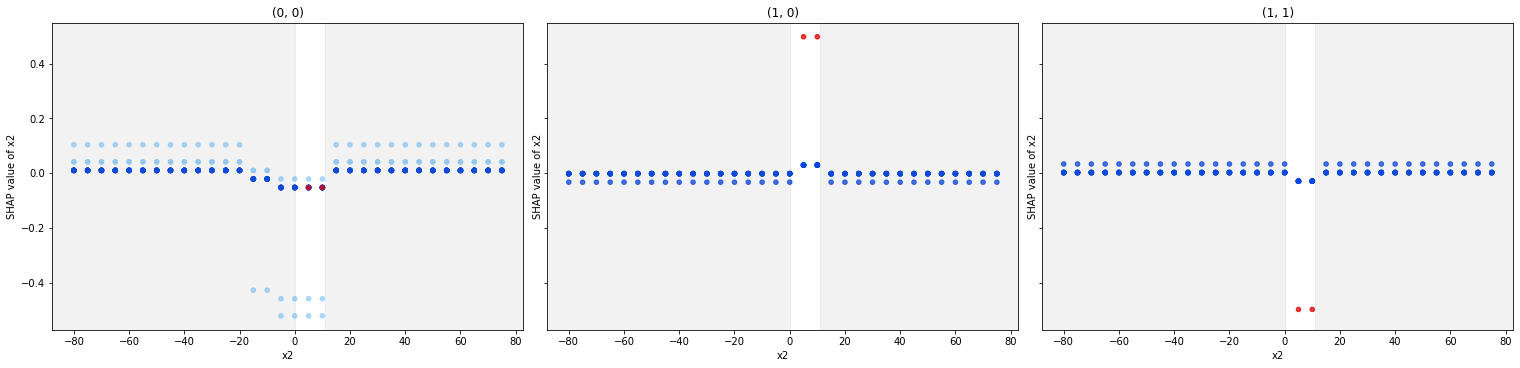

In [35]:
for feature in comparer.feature_names:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

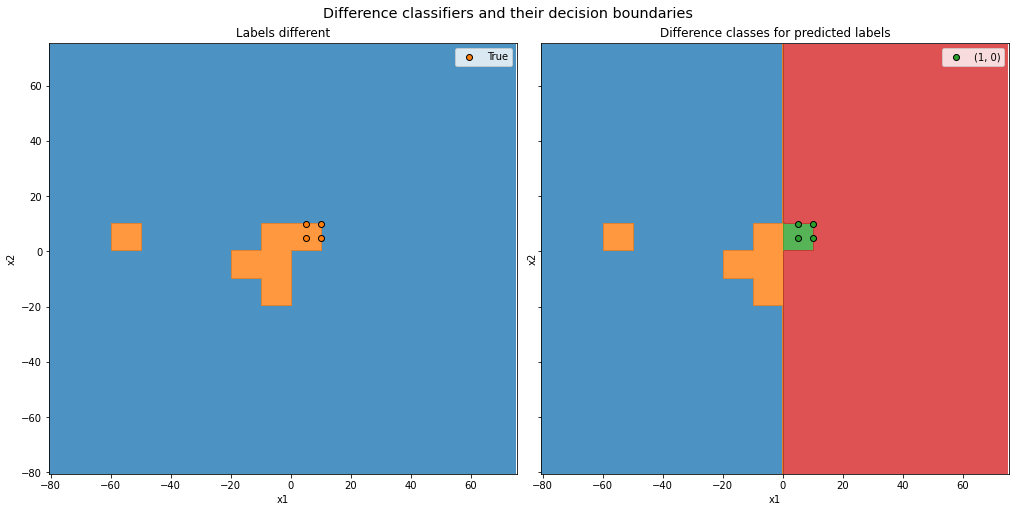

In [58]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

# Explanation

- rule 1 ($(0,1)$/node RLLL): $-20<x1<0.01, -10<x2<0.01 \rightarrow (0,1)$
- rule 2 ($(0,1)$/node RLLR): $-60<x1<-49.99, 0<x2<10.01 \rightarrow (0,1)$
- rule 3 ($(0,1)$/node RLRL): $-10<x1<0.01, -20<x2<10.01 \rightarrow (0,1)$
- rule 4 ($(0,1)$/node RLRRL): $-20<x1<0.01, -20<x2<10.01 \rightarrow (0,1)$
- rule 5 ($(0,1)$/node RLRRR): $-10<x1<0.01, -20<x2<10.01 \rightarrow (0,1)$
- rule 6 ($(1,0)$/node RL): $0<x1<10.01, 0<x2<10.01 \rightarrow (1,0)$

$(0,1)$:
- Differences: $-55 ≤ x1 ≤ 0, -15 ≤ x2 ≤ 10$ (20 instances)
- R: $x1 ≤ 0$
    - CF: $x1≥0.01 \rightarrow (1,1), (1,0)$
    - RL: $x1≥-55, -15 ≤ x2 ≤ 10$
        - CF: $x1≤-60 \rightarrow (0,0)$
        - CF: $x2≤-20 \rightarrow (0,0)$
        - CF: $x2≥10.01 \rightarrow (0,0)$
        - RLL: $x1≤-10, x2≥-5$ (8 instances different)
            - CF: $x2≤-10 \rightarrow (0,0)$
            - RLLL: $x1≥-15, x2≤0$ (4 instances different)
                - CF: $x1≤-20 \rightarrow (0,0)$
                - CF: $x2≥0.01 \rightarrow (0,0)$
            - RLLR: $x1 ≤ -50, x2 ≥ 5$ (4 instances different)
                - CF: $x1≥-49.99 \rightarrow (0,0)$
                - CF: $x2≤0 \rightarrow (0,0)$
        - RLR: $x1≥-5$ (12 instances different)
            - CF: $x1≤-20 \rightarrow (0,0)$
            - RLRL: $x2 ≤ -10$ (4 instances different)
                - CF: $x1≤-10 \rightarrow (0,0)$
                - CF: $x1≥0.01 \rightarrow (1,1)$
            - RLRR: $x2≥-5$ (8 instances different)
                - RLRRL: $x2≤0$ (4 instances different)
                    - CF: $x1≥0.01 \rightarrow (1,1)$
                - RLRRR: $x2≥5$ (4 instances different)
                    - CF: $x1≤-10 \rightarrow (0,0)$
                    - CF: $x1≥0.01 \rightarrow (1,0)$

$(1,0)$:
- Differences: $5≤x1≤10, 5≤x2≤10$ (4 instances)
- R: $x1≥5$
    - CF: $x1≤0 \rightarrow (0,1)$
    - RL: $x1≤10, 5≤x2≤10$
        - CF: $x1≥10.01 \rightarrow (1,1)$
        - CF: $x2≤0 \rightarrow (1,1)$
        - CF: $x2≥10.01 \rightarrow (1,1)$

# Evaluation

## Selectivity
The explanation has 3 more rules than would have been necessary.

## Fidelity
- difference #1 (rules 1, 3, 4, 5): no error
- difference #2 (rule 2): no error
- difference #3: (rule 6): no error

## Predictability
The explanation generalizes to all known differences.

## Persuability
Even though selectivity is compromised by duplicate rules 3 and 5, there is an advantage in that the counterfactuals for the rules provide further details about the boundaries. For rule 5 this means that at the upper boundary of x1 $(1,0)$ is predicted, while for the other rule 3 at the same boundary $(1,1)$ is predicted.

A disadvantage is shown with rule 4. It covers the whole area of difference 1, including those areas where $(0,0)$ is predicted. This may seem wrong at first, but on closer interpretation using the scope of instances classified $(0,1)$, we see that this applies only when either x1 is fixed to values in the range of -5 to 0 or x2 is fixed to -5 to 0. Still, the actual range would be -10 to 0 and -10 to 0 respectively and thus has a fidelity error of 5 each. Further, it's not so easy to interpret and might be missed.